In [1]:
#imports

import pandas as pd
import numpy as np
import math

pd.options.display.max_columns =200
pd.options.display.max_rows =500
pd.options.display.max_colwidth =500

## Get train data 

In [2]:
train = pd.read_csv('train.csv', encoding='windows-1255')

In [3]:
train.head()

,trip_index,bus_id,time_recorded,lat,lon,route_id,line_index
0,3,7508169,18:54:00,32.054939,34.779751,20920,169
1,3,7508169,18:58:01,32.055996,34.779331,20920,173
2,3,7508169,18:59:17,32.056160,34.778408,20920,174
3,3,7508169,19:00:18,32.056400,34.780128,20920,175
4,3,7508169,19:03:13,32.061306,34.784782,20920,178


trip_index = main key

In [4]:
print (len(train), train.trip_index.nunique())

127227 2248


In [5]:
train.drop_duplicates(subset=['trip_index']).route_id.value_counts()

5189     1328
20920     392
20916     268
5214      194
20912      66
Name: route_id, dtype: int64

In [6]:
train.groupby('trip_index').bus_id.nunique().value_counts()

1    2233
2      15
Name: bus_id, dtype: int64

In [7]:
X = pd.DataFrame()
for trip_index in train.trip_index.unique():
    

SyntaxError: unexpected EOF while parsing (<ipython-input-7-483f058e0595>, line 3)

trips with bus change?

## get route_stats data 

In [ ]:
route_stats = pd.read_csv('route_stats.csv', index_col=[0])
#route_stats = pd.read_csv('route_stats_1.csv.gz')

In [ ]:
train[train.trip_index == 3].route_id[0]

In [ ]:
len(route_stats[route_stats.route_id == 20920].all_stop_id.iloc[0].split(";"))

In [ ]:
print (len(route_stats), len(route_stats.drop_duplicates(subset=['route_id','date'])))

## choose relavents dates 

In [ ]:
#START_DATE = pd.datetime(2019,2,1)
#END_DATE = pd.datetime(2019,3,14)

In [ ]:
#print (route_stats['date'].min(),route_stats['date'].max())

In [ ]:
#route_stats = route_stats[(pd.to_datetime(route_stats['date'])>=START_DATE)&
 #                        (pd.to_datetime(route_stats['date'])<=END_DATE)]

In [ ]:
print (route_stats['date'].min(),route_stats['date'].max())

## send route_stats to csv 

In [ ]:
#route_stats.to_csv('route_stats.csv')

## find unique routes 
*driving paths may change from time to time

In [ ]:
route_stats.groupby('route_id').all_stop_id.nunique()

In [ ]:
train.groupby(['trip_index', 'lat','lon']).head()

In [ ]:

train_unique = train.groupby(['trip_index'], as_index=False).g['lat','lon']

In [8]:
train_unique.head()

NameError: name 'train_unique' is not defined

In [ ]:
route_stats_unique = route_stats.groupby(['route_id','all_stop_id','all_stop_latlon'],
                                        as_index=False)['date'].agg(['min','max'])\
                                        .rename(columns = {'min':'start_date', 'max': 'end_date'})\
                                        .reset_index().sort_values(by = ['route_id','start_date'])

In [ ]:
route_stats_unique

## plot routes 

####  route_stats_split_coordinates

In [ ]:
def route_stats_split_coordinates(route_id):
    coordinates_strings = [latlon.split(',') for latlon in route_id.all_stop_latlon.split(';')]
    coordinates_floats = [(float(lat), float(lon)) for lat, lon in coordinates_strings]
    
    return coordinates_floats

In [ ]:
route_stats_unique.apply(lambda r: route_stats_split_coordinates(r), axis=1).tolist()[0][:3]

####  route_stats_split_stops

In [9]:
def route_stats_split_stops(route_id, col):
    return route_id[col].split(';')

In [10]:
route_stats_unique.apply(lambda r: route_stats_split_stops(r, 'all_stop_id'), axis=1).tolist()[0][:3]

NameError: name 'route_stats_unique' is not defined

####  route_stats_2_stops

In [11]:
def route_stats_2_stops(route_stats):
    
    route_stats = route_stats.copy()
    
    route_stats_stops = pd.DataFrame(columns = ['route_id','stop_index','stop_id','coordinates'])
    
    route_stats['all_stop_latlon'] = route_stats.apply(lambda r: route_stats_split_coordinates(r), axis=1)
    route_stats['all_stop_id'] = route_stats.apply(lambda r: route_stats_split_stops(r, 'all_stop_id'), axis=1)
    
    for route_id in route_stats['route_id']:
        route_id_stops = pd.DataFrame()
        route_id_stops['stop_id'] = pd.Series(route_stats[route_stats['route_id']==route_id]['all_stop_id'].tolist()[0])
        route_id_stops['coordinates'] = pd.Series(route_stats[route_stats['route_id']==route_id]['all_stop_latlon'].tolist()[0])
        route_id_stops['stop_index'] = route_id_stops.index+1
        route_id_stops['route_id'] = route_id
        
        route_stats_stops = route_stats_stops.append(route_id_stops)
    
    route_stats_stops = route_stats_stops[['route_id','stop_index','stop_id','coordinates']]\
            .sort_values(by = ['route_id','stop_index'])
    
    return route_stats_stops

In [12]:
route_stats_stops = route_stats_2_stops(route_stats_unique)

NameError: name 'route_stats_unique' is not defined

In [25]:
route_stats_stops.head()

,route_id,stop_index,stop_id,coordinates
0,5189,1,37687,"(32.055909, 34.779084999999995)"
1,5189,2,29310,"(32.061294000000004, 34.784812)"
2,5189,3,29322,"(32.067008, 34.786971)"
3,5189,4,13320,"(32.074292, 34.791025)"
4,5189,5,13354,"(32.083907, 34.795093)"


#### plot with geopandas

In [26]:
%matplotlib inline

from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import geopandas as gpd
#from seaborn import palplot

In [27]:
def plot_route_id_stops(route_stats_stops):
    route_stats_stops['coordinates'] = route_stats_stops['coordinates'].apply(Point)
    gdf = gpd.GeoDataFrame(route_stats_stops, geometry='coordinates')
    
    route_ids = dict(tuple(gdf.groupby('route_id')))
    
    fig = plt.figure(num=None, figsize=(10, 8))
    
    first_route_id = list(route_ids.keys())[0]
    
    ax = route_ids[first_route_id].plot()
    
    for route_id in route_ids.keys():
        if route_id == first_route_id:
            pass
        else:
            route_ids[route_id].plot(ax=ax)
    

<Figure size 720x576 with 0 Axes>

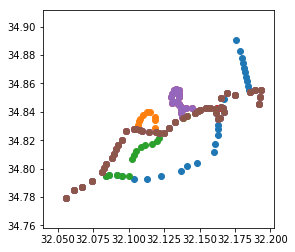

In [28]:
plot_route_id_stops(route_stats_stops)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<Figure size 720x576 with 0 Axes>

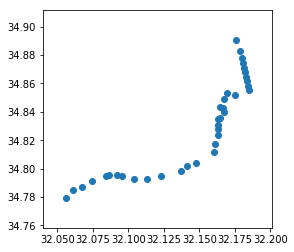

In [29]:
plot_route_id_stops(route_stats_stops[route_stats_stops.route_id==5189])

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<Figure size 720x576 with 0 Axes>

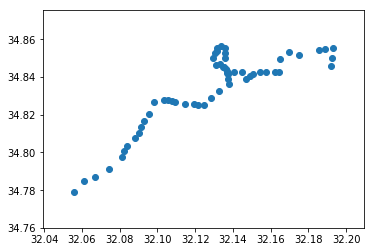

In [30]:
plot_route_id_stops(route_stats_stops[route_stats_stops.route_id.isin([20916])])

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<Figure size 720x576 with 0 Axes>

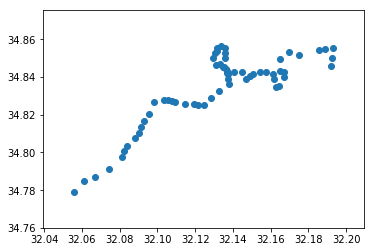

In [31]:
plot_route_id_stops(route_stats_stops[route_stats_stops.route_id.isin([20917])])

route_id 20916 and route_id 20917 are very similar

##  match siri data to route_id using geopandas buffer

### transform route_stats_stops to  GeoDataFrame & set buffer for stops 

In [32]:
def set_buffer(route_stats_stops, buffer_rad = 0.01):
    route_stats_stops['coordinates'] = route_stats_stops['coordinates'].apply(Point)
    gdf = gpd.GeoDataFrame(route_stats_stops, geometry='coordinates')
    gdf['buffer'] = gdf.buffer(buffer_rad)
    gdf.set_index('stop_id', inplace=True, drop=False)
    
    return gdf

In [33]:
route_stats_stops_gdf = set_buffer(route_stats_stops)

In [34]:
route_stats_stops_gdf.head(3)

,route_id,stop_index,stop_id,coordinates,buffer
stop_id,,,,,
37687,5189,1,37687,POINT (32.055909 34.77908499999999),"POLYGON ((32.065909 34.77908499999999, 32.06586084726672 34.7781048285967, 32.06571685280403 34.77713409677983, 32.06547840335733 34.77618215322745, 32.06514779532511 34.77525816567634, 32.06472821264348 34.77437103263173, 32.06422369612302 34.7735292976698, 32.06363910453363 34.77274106715836, 32.06298006781186 34.77201393218813, 32.06225293284164 34.77135489546637, 32.0614647023302 34.77077030387697, 32.06062296736826 34.77026578735651, 32.05973583432365 34.76984620467488, 32.0588118467725..."
29310,5189,2,29310,POINT (32.061294 34.784812),"POLYGON ((32.071294 34.784812, 32.07124584726672 34.7838318285967, 32.07110185280403 34.78286109677984, 32.07086340335733 34.78190915322746, 32.07053279532511 34.78098516567635, 32.07011321264348 34.78009803263174, 32.06960869612303 34.7792562976698, 32.06902410453363 34.77846806715836, 32.06836506781187 34.77774093218814, 32.06763793284164 34.77708189546637, 32.0668497023302 34.77649730387698, 32.06600796736826 34.77599278735652, 32.06512083432366 34.77557320467489, 32.06419684677255 34.775..."
29322,5189,3,29322,POINT (32.067008 34.786971),"POLYGON ((32.077008 34.786971, 32.07695984726672 34.7859908285967, 32.07681585280403 34.78502009677984, 32.07657740335733 34.78406815322746, 32.07624679532511 34.78314416567635, 32.07582721264348 34.78225703263174, 32.07532269612302 34.7814152976698, 32.07473810453363 34.78062706715836, 32.07407906781187 34.77989993218814, 32.07335193284164 34.77924089546637, 32.0725637023302 34.77865630387698, 32.07172196736826 34.77815178735652, 32.07083483432366 34.77773220467489, 32.06991084677254 34.777..."


### transform train to  GeoDataFrame

In [35]:
train.head()

,trip_index,bus_id,time_recorded,lat,lon,route_id,line_index
0,3,7508169,18:54:00,32.054939,34.779751,20920,169
1,3,7508169,18:58:01,32.055996,34.779331,20920,173
2,3,7508169,18:59:17,32.056160,34.778408,20920,174
3,3,7508169,19:00:18,32.056400,34.780128,20920,175
4,3,7508169,19:03:13,32.061306,34.784782,20920,178


In [36]:
train['coordinates'] = list(zip(train.lat, train.lon))
train['coordinates'] = train['coordinates'].apply(Point)

train_gdf = gpd.GeoDataFrame(train, geometry='coordinates')

In [37]:
train_gdf.head()

,trip_index,bus_id,time_recorded,lat,lon,route_id,line_index,coordinates
0,3,7508169,18:54:00,32.054939,34.779751,20920,169,POINT (32.05493927001953 34.77975082397461)
1,3,7508169,18:58:01,32.055996,34.779331,20920,173,POINT (32.05599594116211 34.77933120727539)
2,3,7508169,18:59:17,32.056160,34.778408,20920,174,POINT (32.05615997314453 34.77840805053711)
3,3,7508169,19:00:18,32.056400,34.780128,20920,175,POINT (32.05640029907227 34.78012847900391)
4,3,7508169,19:03:13,32.061306,34.784782,20920,178,POINT (32.06130599975586 34.78478240966797)


### define similarity metric

In [ ]:
def find_route_id_similarity(trip, route_stats_stops_gdf, route_stats_unique):
    similarity_summary = {}
    
    for route_id in route_stats_unique.route_id:
    
        route_id_buffers = route_stats_stops_gdf[route_stats_stops_gdf['route_id']==route_id]['buffer'] 
    
        route_id_stops_results = {key: trip.within(geom) for key, geom in route_id_buffers.items()}
    
        route_id_stops_summary = {}
        for stop in route_id_stops_results.keys():
            route_id_stops_summary[stop] = np.any(route_id_stops_results[stop])
    
        route_id_mean = np.mean(list(route_id_stops_summary.values()))
        
        route_id_count = len(route_id_stops_summary)
    
        similarity_summary[str(route_id)+'_mean'] = [route_id_mean]
        
        similarity_summary[str(route_id)+'_cnt'] = [route_id_count]

    return pd.DataFrame(similarity_summary)
    

In [64]:
train_gdf.groupby(['trip_index',
                'route_id']).head(1)

,trip_index,bus_id,time_recorded,lat,lon,route_id,line_index,coordinates
0,3,7508169,18:54:00,32.054939,34.779751,20920,169,POINT (32.05493927001953 34.77975082397461)
67,4,7793169,06:18:52,32.055027,34.779896,20916,248,POINT (32.05502700805664 34.7798957824707)
142,6,7643869,06:46:22,32.055656,34.779430,5189,405,POINT (32.05565643310547 34.7794303894043)
185,7,7711169,05:45:35,32.055809,34.779369,20916,461,POINT (32.05580902099609 34.77936935424805)
248,8,7535069,17:35:00,32.055634,34.779621,20920,532,POINT (32.05563354492188 34.77962112426758)
321,9,8732901,18:12:14,32.055538,34.779831,5214,633,POINT (32.05553817749023 34.77983093261719)
389,12,8837201,08:07:23,32.055679,34.779434,5189,878,POINT (32.05567932128906 34.77943420410156)
443,13,7643069,20:40:00,32.055576,34.779705,5189,958,POINT (32.05557632446289 34.77970504760742)
496,17,7565269,10:24:01,32.055145,34.779957,20920,1259,POINT (32.05514526367188 34.77995681762695)
565,18,7508769,18:28:01,32.055817,34.779350,20920,1339,POINT (32.05581665039063 34.77935028076172)


In [ ]:
train_similarity_matrix = train_gdf.groupby(['trip_index',
                'route_id']).apply(lambda trip: find_route_id_similarity(trip, route_stats_stops_gdf, route_stats_unique))

long runtime...

In [40]:
train_similarity_matrix.head()

,,,5189_mean,5189_cnt,5214_mean,5214_cnt,20912_mean,20912_cnt,20916_mean,20916_cnt,20917_mean,20917_cnt,20920_mean,20920_cnt
trip_index,route_id,,,,,,,,,,,,,
3,20920,0,0.513514,37,0.913043,46,0.810811,37,0.793103,58,0.809524,63,1.000000,45
4,20916,0,0.459459,37,0.913043,46,0.810811,37,1.000000,58,1.000000,63,1.000000,45
6,5189,0,1.000000,37,0.369565,46,0.513514,37,0.293103,58,0.349206,63,0.488889,45
7,20916,0,0.459459,37,0.913043,46,0.810811,37,1.000000,58,1.000000,63,1.000000,45
8,20920,0,0.513514,37,0.913043,46,0.810811,37,0.793103,58,0.809524,63,1.000000,45


In [41]:
#train_similarity_matrix

###  match trip_index to route_id using  similarity metric

In [42]:
def match_route_id(trip, route_stats_unique, min_match_prob = 0.8, floor_val = 0.05):
    
    match_summary = {}  
    
    # drop route_ids with % prob < min_match_prob
    for route_id in route_stats_unique.route_id:
        
        # for each route 
        if trip[str(route_id)+'_mean'] >=  min_match_prob:
            match_summary[route_id] = round(math.floor(trip[str(route_id)+'_mean'] / floor_val) * floor_val,2)
    
    if not match_summary:
        return 'No match'
    
    else:
    
    # choose best match
        max_match = max(match_summary.values())
        
        match_summary = {key: val for key, val in match_summary.items() if val == max_match}
        
        if len(match_summary) == 1:
            
            # if
            return list(match_summary.keys())[0]
        
        else:
            max_match_route_ids = match_summary.keys()
            match_summary = {} # reset match_summary to contain route_ids number of stops 
            for route_id in max_match_route_ids:
                match_summary[route_id] = trip[str(route_id)+'_cnt']
            
            #match_summary = sorted(match_summary.items(), key=lambda x: x[1], reverse=True)
            
            max_match = max(match_summary.values())
            
            match_summary = {key: val for key, val in match_summary.items() if val == max_match}
            
            if len(match_summary) == 1:
                
                # if
                return list(match_summary.keys())[0]
            else:
                
                # if
                return 'No match' 
    

## for each trip, apply match route id, with unique route stats. and than transform it to dataframe

In [43]:
train_similarity_matrix.tail(1).apply(lambda trip: match_route_id(trip, route_stats_unique), axis=1).to_frame()

,,,0
trip_index,route_id,,
4526,5189,0,5189


In [44]:
train_trips = train_similarity_matrix.apply(lambda trip: match_route_id(trip, route_stats_unique), axis=1).to_frame()

train_trips.rename(columns = {0: 'route_id_pred'}, inplace=True)

train_trips.reset_index(inplace=True)

train_trips.drop(columns=['level_2'], inplace=True)

train_trips['route_id_pred_true'] = np.where(train_trips.route_id==train_trips.route_id_pred,1,0)

In [45]:
train_trips[::200]

,trip_index,route_id,route_id_pred,route_id_pred_true
0,3,20920,20920,1
200,375,20920,20920,1
400,808,20916,20917,0
600,1184,5189,5189,1
800,1589,5189,5189,1
1000,1992,5189,5189,1
1200,2393,5189,5189,1
1400,2796,5189,5189,1
1600,3205,5189,5189,1
1800,3614,20920,20920,1


## Evaluate the model 

### phase 1 - precision and recall

#### recall 

In [46]:
train_trips.groupby('route_id')['route_id_pred_true'].value_counts().unstack().fillna(0).astype(int)

route_id_pred_true,0,1
route_id,,
5189,87,1241
5214,31,163
20912,12,54
20916,268,0
20920,19,373


In [46]:
train_trips.groupby('route_id')['route_id_pred_true'].value_counts(normalize=True).round(2).unstack().fillna(0)

route_id_pred_true,0,1
route_id,,
5189,0.07,0.93
5214,0.16,0.84
20912,0.18,0.82
20916,1.00,0.00
20920,0.05,0.95


In [47]:
train_trips.groupby('route_id')['route_id_pred'].value_counts(normalize=0).round(2).unstack().fillna(0).astype(int)

route_id_pred,5189,5214,20912,20917,20920,No match
route_id,,,,,,
5189,1241,0,0,0,0,87
5214,0,163,0,0,1,30
20912,0,0,54,0,0,12
20916,0,0,0,232,0,36
20920,0,0,0,0,373,19


In [48]:
train_trips.groupby('route_id')['route_id_pred'].value_counts(normalize=True).round(2).unstack().fillna(0)

route_id_pred,5189,5214,20912,20917,20920,No match
route_id,,,,,,
5189,0.93,0.00,0.00,0.00,0.00,0.07
5214,0.00,0.84,0.00,0.00,0.01,0.15
20912,0.00,0.00,0.82,0.00,0.00,0.18
20916,0.00,0.00,0.00,0.87,0.00,0.13
20920,0.00,0.00,0.00,0.00,0.95,0.05


####  precision

In [49]:
train_trips.groupby('route_id_pred')['route_id_pred_true'].value_counts(normalize=0).unstack().fillna(0).astype(int)

route_id_pred_true,0,1
route_id_pred,,
5189,0,1241
5214,0,163
20912,0,54
20917,232,0
20920,1,373
No match,184,0


In [50]:
train_trips.groupby('route_id_pred')['route_id_pred_true'].value_counts(normalize=True).round(2).unstack().fillna(0)

route_id_pred_true,0,1
route_id_pred,,
5189,0.0,1.0
5214,0.0,1.0
20912,0.0,1.0
20917,1.0,0.0
20920,0.0,1.0
No match,1.0,0.0


In [51]:
round(train_trips.route_id_pred_true.mean(),2)

0.81

note that "No match" label doesn't exist in tha real data

### phase 2 - test some examples 

In [52]:
def plot_prediction(trip_index,train_trips = train_trips, train_gdf = train_gdf, route_stats_stops_gdf = route_stats_stops_gdf):
    
    pred = train_gdf[(train_gdf['trip_index']==trip_index)&(train.lat>0)]
    
    route_id = pred.route_id.values[0]
    
    route_id_pred = train_trips[train_trips['trip_index']==trip_index].route_id_pred.values[0]
    
    actual = route_stats_stops_gdf[(route_stats_stops_gdf['route_id']==route_id)]
    
    title = 'trip_index: {} - pred: {}, actual: {}'.format(trip_index, route_id_pred, route_id)
    
    fig = plt.figure(num=None, figsize=(10, 8))
    
    ax = actual.plot(markersize=200)
    
    ax.set_title(title)
    
    pred.plot(ax=ax)
    

In [53]:
train_trips.merge(train_similarity_matrix, on = 'trip_index', how = 'inner')[::500]

,trip_index,route_id,route_id_pred,route_id_pred_true,5189_mean,5189_cnt,5214_mean,5214_cnt,20912_mean,20912_cnt,20916_mean,20916_cnt,20917_mean,20917_cnt,20920_mean,20920_cnt
0,3,20920,20920,1,0.513514,37,0.913043,46,0.810811,37,0.793103,58,0.809524,63,1.000000,45
500,986,5189,5189,1,1.000000,37,0.369565,46,0.513514,37,0.293103,58,0.349206,63,0.488889,45
1000,1992,5189,5189,1,1.000000,37,0.369565,46,0.513514,37,0.293103,58,0.349206,63,0.488889,45
1500,3008,20916,No match,0,0.054054,37,0.043478,46,0.054054,37,0.034483,58,0.031746,63,0.044444,45
2000,4011,5214,5214,1,0.459459,37,1.000000,46,0.783784,37,0.793103,58,0.809524,63,1.000000,45


#### "No Match" pred 

<Figure size 720x576 with 0 Axes>

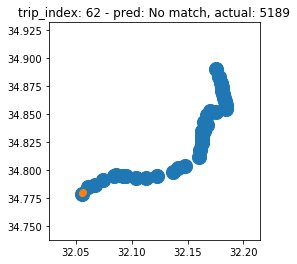

In [54]:
plot_prediction(62)

<Figure size 720x576 with 0 Axes>

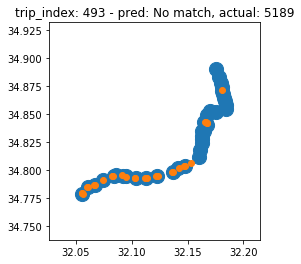

In [55]:
plot_prediction(493)

<Figure size 720x576 with 0 Axes>

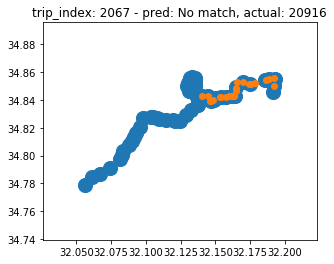

In [56]:
plot_prediction(2067)

#### True pred

<Figure size 720x576 with 0 Axes>

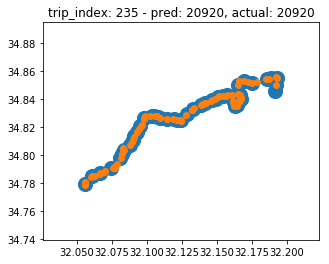

In [57]:
plot_prediction(235)

<Figure size 720x576 with 0 Axes>

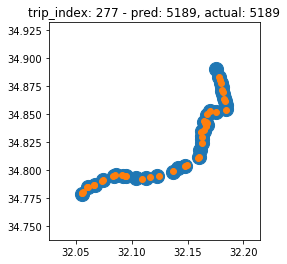

In [58]:
plot_prediction(277)

#### False Pred

<Figure size 720x576 with 0 Axes>

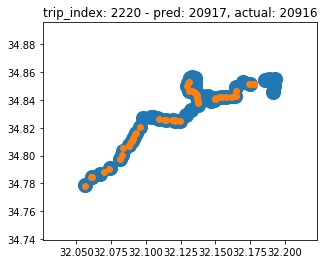

In [59]:
plot_prediction(2220)

<Figure size 720x576 with 0 Axes>

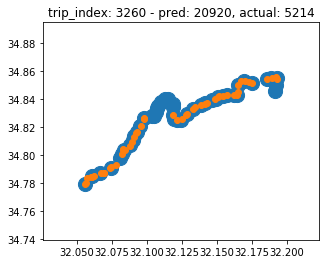

In [60]:
plot_prediction(3260)

# Test 

### get test data 

In [61]:
test = pd.read_csv('test.csv', encoding='windows-1255')

In [62]:
test.head()

,trip_index,bus_id,time_recorded,lat,lon,line_index
0,1,8878101,15:29:00,32.055294,34.779953,0
1,1,8878101,15:34:01,32.055889,34.779289,5
2,1,8878101,15:35:12,32.056080,34.778332,6
3,1,8878101,15:38:34,32.058559,34.784031,9
4,1,8878101,15:39:33,32.060497,34.784584,10


### transform test to GeoDataFrame 

In [63]:
test['coordinates'] = list(zip(test.lat, test.lon))
test['coordinates'] = test['coordinates'].apply(Point)

test_gdf = gpd.GeoDataFrame(test, geometry='coordinates')

### use similarity metric - test data

In [64]:
test_similarity_matrix = test_gdf.groupby(['trip_index'])\
                .apply(lambda trip: find_route_id_similarity(trip, route_stats_stops_gdf, route_stats_unique))

###  match using  similarity metric - test data 

In [65]:
test_trips = test_similarity_matrix.apply(lambda trip: match_route_id(trip, route_stats_unique), axis=1).to_frame()

test_trips.rename(columns = {0: 'route_id_pred'}, inplace=True)

test_trips.reset_index(inplace=True)

test_trips.drop(columns=['level_1'], inplace=True)

### send test results to csv

In [66]:
test_trips.head()

,trip_index,route_id_pred
0,1,5189
1,2,5189
2,5,5189
3,10,5189
4,11,20920


In [67]:
test_trips.to_csv('test_trips.csv')